Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = ""
COLLABORATORS = ""

---

# DataTables, Indexes, Pandas, and Seaborn

## Some useful (free) resources

Introductory:

* [Getting started with Python for research](https://github.com/TiesdeKok/LearnPythonforResearch), a gentle introduction to Python in data-intensive research.

* [A Whirlwind Tour of Python](https://jakevdp.github.io/WhirlwindTourOfPython/index.html), by Jake VanderPlas, another quick Python intro (with notebooks).

Core Pandas/Data Science books:

* [The Python Data Science Handbook](https://jakevdp.github.io/PythonDataScienceHandbook/), by Jake VanderPlas.

* [Python for Data Analysis, 2nd Edition](http://proquest.safaribooksonline.com/book/programming/python/9781491957653), by  Wes McKinney, creator of Pandas. [Companion Notebooks](https://github.com/wesm/pydata-book)

* [Effective Pandas](https://github.com/TomAugspurger/effective-pandas), a book by Tom Augspurger, core Pandas developer.


Complementary resources:

* [An introduction to "Data Science"](https://github.com/stefanv/ds_intro), a collection of Notebooks by BIDS' [Stéfan Van der Walt](https://bids.berkeley.edu/people/st%C3%A9fan-van-der-walt).

* [Effective Computation in Physics](http://proquest.safaribooksonline.com/book/physics/9781491901564), by Kathryn D. Huff; Anthony Scopatz. [Notebooks to accompany the book](https://github.com/physics-codes/seminar). Don't be fooled by the title, it's a great book on modern computational practices with very little that's physics-specific.


OK, let's load and configure some of our core libraries (as an aside, you can find a nice visual gallery of available matplotlib sytles [here](https://tonysyu.github.io/raw_content/matplotlib-style-gallery/gallery.html)).

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

plt.style.use('fivethirtyeight')
sns.set_context("notebook")

## Getting the Data

https://www.ssa.gov/OACT/babynames/index.html

https://www.ssa.gov/data

As we saw before, we can download data from the internet with Python, and do so only if needed:

In [3]:
import requests
from pathlib import Path

namesbystate_path = Path('namesbystate.zip')
data_url = 'https://www.ssa.gov/oact/babynames/state/namesbystate.zip'

if not namesbystate_path.exists():
    print('Downloading...', end=' ')
    resp = requests.get(data_url)
    with namesbystate_path.open('wb') as f:
        f.write(resp.content)
    print('Done!')

## Question 2: Most popular names in all states for each year of each gender?

### Put all DFs together

Again, we'll work off our in-memory, compressed zip archive and pull the data out of it into Pandas DataFrames without ever putting it all on disk. We can see how large the compressed and uncompressed data is:

In [4]:
import zipfile
zf = zipfile.ZipFile(namesbystate_path, 'r')
sum(f.file_size for f in zf.filelist)/1_000_000

122.38892

In [5]:
sum(f.compress_size for f in zf.filelist)/1_000_000

21.568281

In [6]:
__/_  # divide the next-previous result by the previous one

5.674486529547719

We want a single huge dataframe containing every state's data. Let's start by reading in the dataframe for each state into a Python list of dataframes.

In [7]:
%%time
data_frames_for_all_states = []

field_names = ['State', 'Sex', 'Year', 'Name', 'Count']
i = 0
for f in zf.filelist:
    i += 1
    if not f.filename.endswith('.TXT'):
        continue
    if (i > 51):
        break
    with zf.open(f) as fh:
        data_frames_for_all_states.append(pd.read_csv(fh, header=None, names=field_names))

CPU times: user 4.71 s, sys: 829 ms, total: 5.54 s
Wall time: 5.08 s


Now, we create a single DataFrame by concatenating these into one:

In [35]:
baby_names = pd.concat(data_frames_for_all_states).reset_index(drop=True)
baby_names.tail()

,State,Sex,Year,Name,Count
5905782,WV,M,2017,Sutton,5
5905783,WV,M,2017,Sylas,5
5905784,WV,M,2017,Tatum,5
5905785,WV,M,2017,Tripp,5
5905786,WV,M,2017,Zeke,5


In [9]:
baby_names.shape

(5905787, 5)

### Group by state and year

In [10]:
baby_names[
    (baby_names['State'] == 'CA')
    & (baby_names['Year'] == 1995)
    & (baby_names['Sex'] == 'M')
].head()

# The lame way to build our DataFrame would be to manually write down
# the answers for all combinations of State, Year, and Sex.

,State,Sex,Year,Name,Count
685081,CA,M,1995,Daniel,5003
685082,CA,M,1995,Michael,4783
685083,CA,M,1995,Jose,4572
685084,CA,M,1995,Christopher,4098
685085,CA,M,1995,David,4029


In [11]:
%%time


baby_names.groupby('State').size().head()

CPU times: user 444 ms, sys: 22.2 ms, total: 467 ms
Wall time: 312 ms


State
AK     28084
AL    132065
AR    100157
AZ    113111
CA    374634
dtype: int64

In [12]:
state_counts = baby_names.loc[:, ('State', 'Count')]
state_counts.head()

,State,Count
0,AK,14
1,AK,12
2,AK,10
3,AK,8
4,AK,7


In [13]:
sg = state_counts.groupby('State')
sg

In [14]:
state_counts.groupby('State').sum().head()

,Count
State,
AK,430161
AL,5815853
AR,3433745
AZ,3598468
CA,30527811


For Data 8 veterans, this is equivalent to this code from Data 8:

    state_and_groups.group('State', np.sum)
    
In pandas, could also use agg here, yielding:

    state_counts.groupby('State').agg(np.sum)

### Grouping by multiple columns

In [15]:
baby_names.groupby(['State', 'Year']).size().head(3)

State  Year
AK     1910    16
       1911    11
       1912    20
dtype: int64

In [16]:
baby_names.groupby(['State', 'Year']).sum().head(3)

Count
State Year       
AK    1910    115
      1911     84
      1912    141

In [17]:
baby_names.groupby(['State', 'Year', 'Sex']).sum().head()

Count
State Year Sex       
AK    1910 F       68
           M       47
      1911 F       44
           M       40
      1912 F       82

In [18]:
#%%time
def first(series):
    '''Returns the first value in the series.'''
    return series.iloc[0]

most_popular_names = baby_names.groupby(['State', 'Year', 'Sex']).agg(first)

most_popular_names.head()

Name  Count
State Year Sex             
AK    1910 F    Mary     14
           M    John      8
      1911 F    Mary     12
           M    John     15
      1912 F    Mary      9

As we'd expect, we get a MultiIndexed DataFrame, which we can index using [] just like our single indexed DataFrames.

In [19]:
most_popular_names[most_popular_names['Name'] == 'Samuel']

,,,Name,Count
State,Year,Sex,,
ID,2010,M,Samuel,114


`.loc` is a bit more complicated:

In [20]:
most_popular_names.loc['CA', 2017, :, :]

Name  Count
State Year Sex             
CA    2017 F    Emma   2726
           M    Noah   2511

In [21]:
most_popular_names.loc['CA', 1997, 'M', :]

,,,Name,Count
State,Year,Sex,,
CA,1997,M,Daniel,4452


In [22]:
most_popular_names.loc['CA', 1997, 'M']

Name     Daniel
Count      4452
Name: (CA, 1997, M), dtype: object

## Question 3: Can I deduce birth sex from the last letter of a person’s name?

### Compute last letter of each name

In [23]:
baby_names.head()

,State,Sex,Year,Name,Count
0,AK,F,1910,Mary,14
1,AK,F,1910,Annie,12
2,AK,F,1910,Anna,10
3,AK,F,1910,Margaret,8
4,AK,F,1910,Helen,7


In [24]:
baby_names['Name'].apply(len).head()

0    4
1    5
2    4
3    8
4    5
Name: Name, dtype: int64

In [25]:
baby_names['Name'].str.len().head()

0    4
1    5
2    4
3    8
4    5
Name: Name, dtype: int64

In [26]:
baby_names['Name'].str[-1].head()

0    y
1    e
2    a
3    t
4    n
Name: Name, dtype: object

To add column to dataframe:

In [27]:
baby_names['Last letter'] = baby_names['Name'].str[-1]
baby_names.head()

,State,Sex,Year,Name,Count,Last letter
0,AK,F,1910,Mary,14,y
1,AK,F,1910,Annie,12,e
2,AK,F,1910,Anna,10,a
3,AK,F,1910,Margaret,8,t
4,AK,F,1910,Helen,7,n


### Group by last letter and sex

In [28]:
letter_counts = (baby_names
                 .loc[:, ('Sex', 'Count', 'Last letter')]
                 .groupby(['Last letter', 'Sex'])
                 .sum())
letter_counts.head()

Count
Last letter Sex          
a           F    49618993
            M     1606538
b           F       10029
            M     1389618
c           F       19264

### Visualize our result

Use .plot to get some basic plotting functionality:

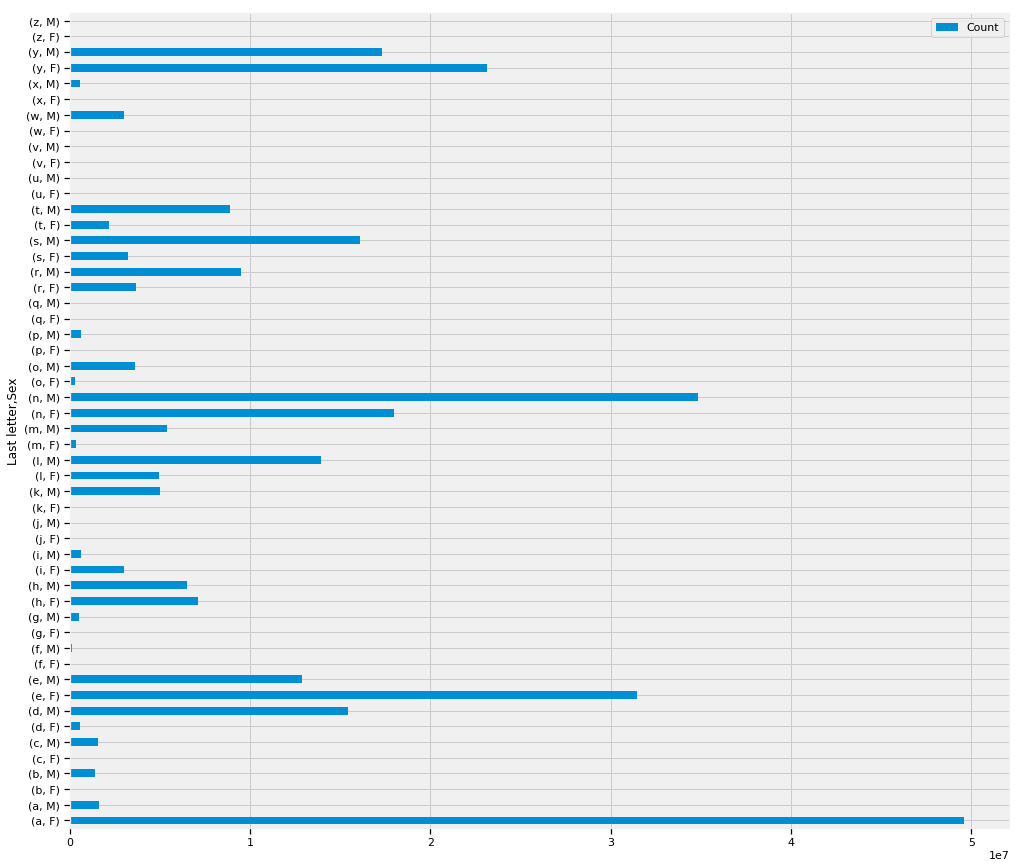

In [29]:
# Why is this not good?
letter_counts.plot.barh(figsize=(15, 15));

Reading the docs shows me that pandas will make one set of bars for each column in my table. How do I move each sex into its own column? I have to use pivot:

In [30]:
# For comparison, the group above:
# letter_counts = (baby_names
#                  .loc[:, ('Sex', 'Count', 'Last letter')]
#                  .groupby(['Last letter', 'Sex'])
#                  .sum())

last_letter_pivot = baby_names.pivot_table(
    index='Last letter', # the rows (turned into index)
    columns='Sex', # the column values
    values='Count', # the field(s) to processed in each group
    aggfunc=sum, # group operation
)
last_letter_pivot.head()

Sex,F,M
Last letter,,
a,49618993,1606538
b,10029,1389618
c,19264,1582422
d,566303,15431983
e,31435817,12863704


---

### Slides: GroupBy/Pivot comparison slides and Quiz

At this point, I highly recommend [this very nice tutorial on Pivot Tables](http://pbpython.com/pandas-pivot-table-explained.html).

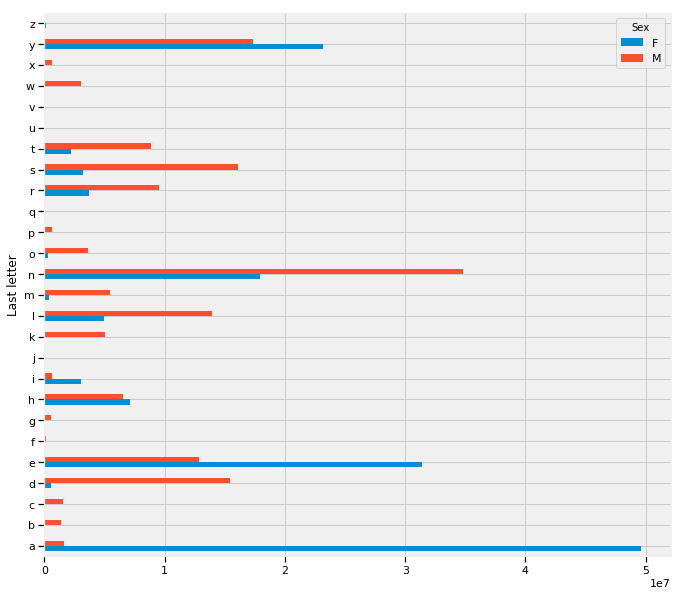

In [31]:
last_letter_pivot.plot.barh(figsize=(10, 10));

Why is this still not ideal?

- Plotting raw counts
- Not sorted by any order

In [32]:
totals = last_letter_pivot['F'] + last_letter_pivot['M']

last_letter_props = pd.DataFrame({
    'F': last_letter_pivot['F'] / totals,
    'M': last_letter_pivot['M'] / totals,
}).sort_values('M')
last_letter_props.head()

,F,M
Last letter,,
a,0.968638,0.031362
i,0.823175,0.176825
e,0.709620,0.290380
z,0.638642,0.361358
y,0.572034,0.427966


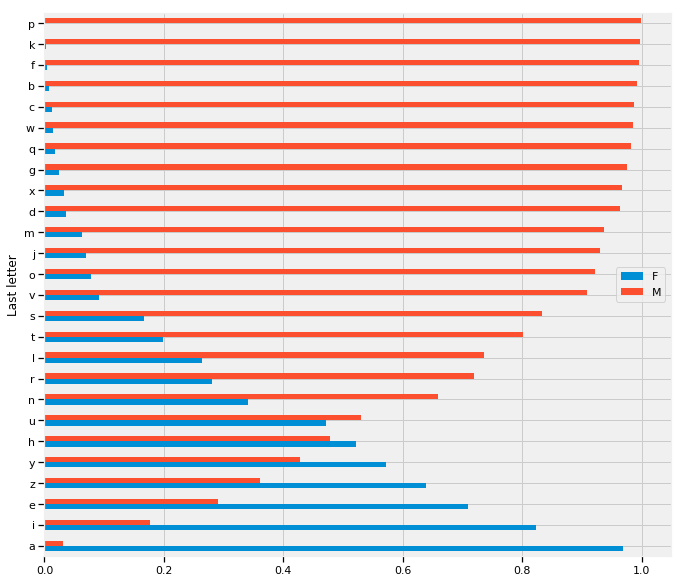

In [33]:
last_letter_props.plot.barh(figsize=(10, 10));

What do you notice?

## Submission

You're done!

Before submitting this assignment, ensure to:

1. Restart the Kernel (in the menubar, select Kernel->Restart & Run All)
2. Validate the notebook by clicking the "Validate" button

Finally, make sure to **submit** the assignment via the Assignments tab in Datahub